In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import numpy as np
import pylab as plt
import h5py
from lal import MSUN_SI, C_SI, PC_SI, MTSUN_SI, PI
from pycbc.types.timeseries import TimeSeries
import pycbc.noise
import pycbc.psd
import scipy
from pycbc.detector import Detector, gmst_accurate
from pycbc.waveform import get_td_waveform
from pycbc import frame
import os
from pycbc.filter import sigma
import pycbc.conversions as convert
from pycbc.coordinates import cartesian_to_spherical
from pycbc.waveform import waveform_modes
from pycbc.waveform.utils import taper_timeseries, td_taper
import pandas as pd

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/sims_from_Prayush_Vaishak/'
category = 'ICTSEccParallel'
lev = 'Lev3'

In [4]:
table_sim_metadata = pd.read_csv(os.path.join(base_dir, 
                                              category, 
                                              '{}_ref_time.csv'.format(category))).set_index('SimulationAlias').T
table_sim_metadata = table_sim_metadata.drop(['Sl.No.', 'RequestedReferenceTime', 'Ncycles(2,2)'])
table_sim_metadata

SimulationAlias,ICTSEccParallel01,ICTSEccParallel02,ICTSEccParallel03,ICTSEccParallel04,ICTSEccParallel05,ICTSEccParallel06,ICTSEccParallel07,ICTSEccParallel08,ICTSEccParallel09,ICTSEccParallel10,ICTSEccParallel11,ICTSEccParallel12,ICTSEccParallel13,ICTSEccParallel14,ICTSEccParallel15,ICTSEccParallel16,ICTSEccParallel17
Status,"{2:'Completed',3:'Completed'}","{2:'Completed',3:'Completed'}","{2:'Completed',3:'Completed'}","{2:'Completed',3:'Completed'}","{2:'Completed',3:'Completed'}","{2:'Completed',3:'Completed'}","{2:'Completed',3:'Completed'}","{2:'Completed',3:'Completed'}",{3:'Running'},"{2:'Completed',3:'Completed'}","{2:'Unknown',3:'Halted'}","{2:'Error',3:'Completed'}","{2:'Completed',3:'Unknown'}","{2:'Completed',3:'Completed'}","{2:'Completed',3:'Halted'}","{2:'Completed',3:'Completed'}","{2:'Completed',3:'Completed'}"
Omega0,0.015218,0.012065,0.028386,0.028486,0.028528,0.020279,0.024527,0.036893,0.004564,0.01717,0.012578,0.012577,0.012577,0.012577,0.012594,0.012594,0.012594
Ncycles,"{2:48.39433257277633,3:48.37193576690978}","{2:60.79164475437962,3:60.74888914239595}","{2:15.418839986900768,3:15.402097333178874}","{2:17.542971285454605,3:17.512670219519514}","{2:10.05280249392835,3:10.05279658387064}","{2:18.67366574703785,3:18.673537808836816}","{2:38.38493651014642,3:38.40542563100516}","{2:16.796344433755152,3:16.777482049067693}",{},"{2:84.5241249247341,3:82.51455931380978}",{},"{2:115.62290286961056,3:114.60591880183198}",{2:135.11902431622948},"{2:62.42457597447514,3:59.84811252443887}",{2:73.1265915587726},"{2:84.21377799921035,3:84.06952658008673}","{2:42.309785790523215,3:42.298155362443495}"
adot0,0.000194,0.000792,0.0,0.0,0.0,-0.001394,0.001482,0.0,9.47404,-0.000457,-0.000721,-0.000721,-0.000721,-0.000721,-0.000722,-0.000722,-0.000722
D0,15.4136,17.9896,9.9,9.9,9.9,12.0799,10.7901,8.36,33.2806,14.3231,17.1104,17.1103,17.1103,17.1103,17.1107,17.1107,17.1107
MassRatio,3.0,2.5,3.5,2.0,1.4,9.0,8.0,5.0,11.0,11.0,9.0,9.5,9.5,9.5,5.0,5.0,5.0
ChiA,"(0.3,0.0,0.0)","(-0.1,-0.4,0.0)","(0.2,0.1,0.0)","(0.0,0.0,0.4)","(0.0,0.0,-0.5)","(0.1,-0.3,-0.2)","(0.0,0.0,0.5)","(0.0,0.0,0.1)","(0.0,0.0,-0.4)","(0.0,0.0,-0.4)","(0.0,0.0,0.5)","(0.0,0.0,0.3)","(0.0,0.0,0.6)","(0.0,0.0,-0.6)","(0.0,0.0,0.3)","(0.0,0.0,0.6)","(0.0,0.0,-0.6)"
ChiB,"(0.3,0.0,0.0)","(0.1,0.4,0.0)","(0.2,0.1,0.0)","(0.0,0.0,0.2)","(0.0,0.0,0.2)","(0.0,0.0,0.1)","(0.0,0.0,-0.2)","(0.0,0.0,-0.2)","(0.0,0.0,0.2)","(0.0,0.0,0.2)","(0.0,0.0,-0.4)","(0.0,0.0,0.3)","(0.0,0.0,0.3)","(0.0,0.0,-0.3)","(0.0,0.0,0.3)","(0.0,0.0,0.3)","(0.0,0.0,-0.3)"
IDType,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK,SHK
ReferenceTime,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
nr_approx = 'ICTSEccParallel01'
inj_num = 1
print('\n', nr_approx, ', inj_num =', inj_num, '\n\n')


 ICTSEccParallel01 , inj_num = 1 




In [6]:
def f_from_x(x, total_mass):
    """
    Parameters:
    ----------------------------------
    x: float
       dimensionless orbital frequency
    total_mass: float
                Total mass of the system (in solar masses)
                
    ------------------------------------------------------------
    Returns: frequency (in Hz) corresponding to x for the given total_mass
    """
    return (x**(3/2))/(np.pi*total_mass*MTSUN_SI)

## Find the lowest total mass possible

In [7]:
x_ref = table_sim_metadata[nr_approx]['Omega_ref']**(2/3)
x_ref_with_5_percent_margin = (table_sim_metadata[nr_approx]['Omega_ref']*1.05)**(2/3)
M_lowest = f_from_x(x_ref_with_5_percent_margin, 1)/20
print('M_lowest = {}'.format(M_lowest))

M_lowest = 53.33501814540652


In [8]:
M = np.ceil(M_lowest)
if M<=30:
    M=30
print('Total mass taken = {}'.format(M))
#e0_table = pd.read_csv('e0_SXS_for_20Hz_M_70.csv').set_index('simulation').T
#e0_table = pd.read_csv('e0_SXS_1169_1174_for_20Hz_M_51.csv').set_index('simulation').T
#e0_table = pd.read_csv('e0_SXS_0318_0322_0323_for_20Hz_M_48.csv').set_index('simulation').T

Total mass taken = 54.0


In [9]:
#paths for my laptop

#for laptop
wf_files_path = os.path.join(base_dir, category)
injections_dir = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/'
out_dir = os.path.join(injections_dir, 'ICTS_sims', lev, nr_approx, 'zero_noise')
plot_dir = out_dir

#for powehi
#wf_files_path = '/home/divyajyoti/eccentric_population/SXS_waveform_files'
#out_dir = '/home/divyajyoti/eccentric_population/injections/%ss/%s/zero_noise/'%(wf_type, nr_approx)
#plot_dir = out_dir

#for CIT and IUCAA
#wf_files_path = '/home/divyajyoti.nln/eccentric_population/SXS_waveform_files/'
#out_dir = '/home/divyajyoti.nln/eccentric_population/injections/%ss/%s/zero_noise/'%(wf_type, nr_approx)
#plot_dir = '/home/divyajyoti.nln/public_html/eccentric_population/%ss/%s/zero_noise/'%(wf_type, nr_approx)

In [10]:
os.system('mkdir -p {}'.format(os.path.join(out_dir, 'inj%s'%inj_num)))
os.system('mkdir -p {}'.format(os.path.join(plot_dir, 'inj%s'%inj_num)))

0

## Waveform

In [11]:
def M_by_R(total_mass, dist):
    """
    Parameters:
    total_mass: total mass (M) in M_Sun
    dist: Luminosity distance (R) in Mpc
    Returns M/R in dimensionless units
    """
    dist_in_m = dist*PC_SI*10**6  #distance in meters
    mass_in_m = total_mass*MTSUN_SI*C_SI  #total mass in meters
    return(mass_in_m/dist_in_m)

In [12]:
DL = 410
iota = np.pi/6

t_gps = 1137283217.0
gmst = gmst_accurate(t_gps)

#ra = 1.7
#dec = 1.7
#pol = 0.2

def calc_ra_dec_pol(theta, phi, psi, gmst_time):
    """
    Parameters: sky angles theta, phi, psi, and gmst time (all in radians)
    Returns: ra, dec, pol (in radians)
    """
    ra = phi + gmst_time
    dec = np.pi/2 - theta
    pol = psi
    return(ra, dec, pol)

ra, dec, pol = calc_ra_dec_pol(np.pi/6, np.pi/4, np.pi/3, gmst)

IFOs = ['L1', 'H1', 'V1']

srate = 4096

modes:  [[2, 2], [2, -2]]


In [13]:
modes = [[2,2], [2,-2]]

print('modes: ',modes)

hp = 0
hc = 0
chi_eff_from_metadata = None
chi_p_from_metadata = None
for mode in modes:
    print('\nRunning', mode)
    
    wf_file = os.path.join(wf_files_path, '{}_{}_data_{}{}_mode.h5'.format(category, lev, 
                                                                           mode[0], mode[1]))
    Y_lm = waveform_modes.get_glm(mode[0], mode[1], iota)  #taking phi_0 = 0
    
    with h5py.File(wf_file, 'r+') as data_from_file:
        approx_data = data_from_file[nr_approx]

        q = approx_data['MassRatio'][0]
        x_ref = approx_data['x_ref'][0]
        try:
            e_ref = approx_data['Eccentricity'][0]
        except KeyError:
            print('Eccentricity value not found for simulation')
        chi_1z_ref = approx_data['ChiA_ref_z'][0]
        chi_1x_ref = approx_data['ChiA_ref_x'][0]
        chi_1y_ref = approx_data['ChiA_ref_y'][0]
        
        chi_2z_ref = approx_data['ChiB_ref_z'][0]
        chi_2x_ref = approx_data['ChiB_ref_x'][0]
        chi_2y_ref = approx_data['ChiB_ref_y'][0]

        try:
            chi_eff_from_metadata = approx_data['ChiEff'][0]
            if mode==[2, 2]:
                print('chi_eff value found in metadata.')
        except:
            pass

        try:
            chi_p_from_metadata = approx_data['ChiPrec'][0]
            if mode==[2, 2]:
                print('chi_p value found in metadata.')
        except:
            pass
        
        t_by_M = approx_data['t_by_M'][:]
        Re_rh_by_M = approx_data['Real_rh_by_M'][:]
        Im_rh_by_M = approx_data['Imag_rh_by_M'][:]
        try:
            t_ref = approx_data['ReqRefTime'][0]
        except KeyError:
            print('ReferenceTime data not available. Taking t_ref=0')
        complete = approx_data['Complete'][0]
        data_from_file.close()

    if complete==0:
        raise Exception('The simulation is not complete! Not recommended for analysis.')
        
    #Converting data from geometric units into approriate units below
    #eref_at_tref = table_sxs_metadata[nr_approx]['e_ref']

    #t_ref is the time before which the SXS data is not reliable, 
    #hence converting the points before this time to 0.
    if t_ref!=0:
        print('Removing junk data before reference time...')
        tref_idx = np.argmin(abs(t_by_M-t_ref))
        Re_rh_by_M[:tref_idx] = 0   
        Im_rh_by_M[:tref_idx] = 0

    t = t_by_M*M*MTSUN_SI  #Multiply by total mass in seconds
    hp += Re_rh_by_M*M_by_R(M, DL)*Y_lm
    hc += -Im_rh_by_M*M_by_R(M, DL)*Y_lm
print('Done!')


Running [2, 2]
chi_eff value found in metadata.
chi_p value found in metadata.
Removing junk data before reference time...

Running [2, -2]
Removing junk data before reference time...
Done!


In [14]:
m1 = convert.mass1_from_mtotal_q(M, q)
m2 = convert.mass2_from_mtotal_q(M, q)
eta = convert.eta_from_q(q)
m_chirp = convert.mchirp_from_mass1_mass2(m1, m2)

chi_eff_ref = convert.chi_eff(m1, m2, chi_1z_ref, chi_2z_ref)
chi_p_ref = convert.chi_p(m1, m2, chi_1x_ref, chi_1y_ref, chi_2x_ref, chi_2y_ref)

if chi_eff_from_metadata != None:
    if round(chi_eff_from_metadata, 3) == round(chi_eff_ref, 3):
        print('chi_eff =', chi_eff_ref)
        pass
    else:
        print('chi_eff from metadata = ', chi_eff_from_metadata)
        print('chi_eff from calculation = ', chi_eff_ref, '\n')

if chi_p_from_metadata != None:
    if round(chi_p_from_metadata, 3) == round(chi_p_ref, 3):
        print('chi_p =', chi_p_ref)
        pass
    else:
        print('chi_p from metadata = ', chi_p_from_metadata)
        print('chi_p from calculation = ', chi_p_ref)

# convert the spins to spherical polar to store in metadata
# This is because the precessing spin recoveries are typically sampled in spherical polar coordinates.

spin1_a, spin1_azimuthal, spin1_polar = cartesian_to_spherical(chi_1x_ref, 
                                                               chi_1y_ref, 
                                                               chi_1z_ref)
spin2_a, spin2_azimuthal, spin2_polar = cartesian_to_spherical(chi_2x_ref, 
                                                               chi_2y_ref, 
                                                               chi_2z_ref)

chi_eff = 0.00048750000000000003
chi_p = 0.30000019499993663


In [15]:
f_low_sim = (x_ref**(3/2))/(np.pi*M*MTSUN_SI)
if f_low_sim >=20:
    f_low = f_low_sim
else:
    f_low = 20
print('f_low = %s\n'%f_low)

f_low = 20



In [16]:
hp_interp = scipy.interpolate.interp1d(t, hp)
hc_interp = scipy.interpolate.interp1d(t, hc)
t_arr = np.arange(t[0], t[-1], 1.0 / srate)

hp_arr = (hp_interp(t_arr))
hc_arr = (hc_interp(t_arr))
ht_arr = hp_arr + 1j*hc_arr

In [17]:
t_peak_idx = np.argmax(np.abs(ht_arr))
t_peak = t_arr[t_peak_idx]
t_peak_to_end = t_arr[-1] - t_peak
t_start_to_peak = t_peak - t_arr[0]
print(f"Waveform ends {t_peak_to_end:f} seconds after peak.")
print("Full waveform length from start to peak =", t_start_to_peak, '\n')

t_shifted = (t_arr - t_arr[t_peak_idx])

t_ref_in_sec = t_ref*M*MTSUN_SI
print('t_ref (in seconds) = ', t_ref_in_sec)

rough_dur = pycbc.waveform.compress.rough_time_estimate(m1, m2, f_low)
print('Rough signal duration = ', rough_dur)

Waveform ends 0.041260 seconds after peak.
Full waveform length from start to peak = 1.8134765625 

t_ref (in seconds) =  0.08192076544116955
Rough signal duration =  1.6914355653768423


## Plot waveform before projecting

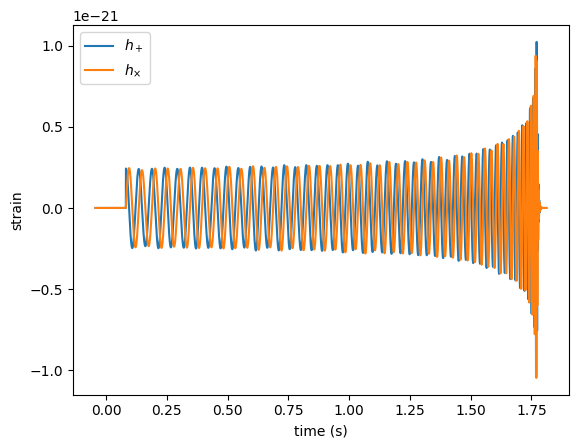

In [18]:
plt.figure()
plt.plot(t_arr, hp_arr, label='$h_+$')
plt.plot(t_arr, hc_arr, label='$h_{\\times}$')
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.legend()
plt.savefig(os.path.join(out_dir, 'inj%s'%inj_num, 'waveform_source.png'), dpi=200)
plt.savefig(os.path.join(plot_dir, 'inj%s'%inj_num, 'waveform_source.png'), dpi=200)

## Project the signal into detector

L1: fp=-0.08165397395218339, fc=0.15314988422641218
H1: fp=0.19470894533436345, fc=-0.22390719682895593
V1: fp=-0.8109724889826843, fc=0.3879718869298675




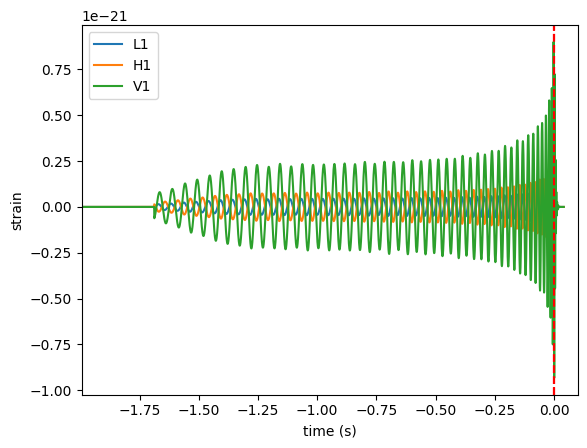

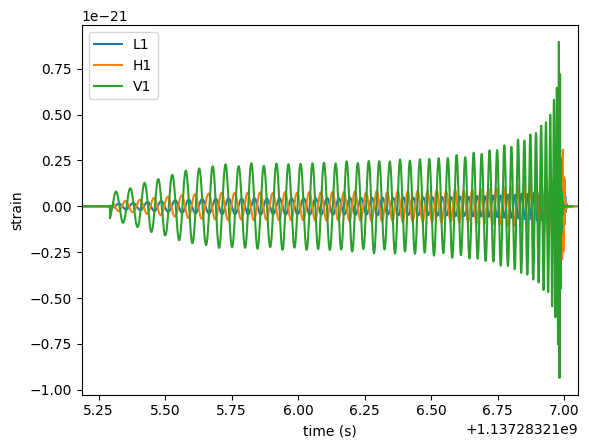

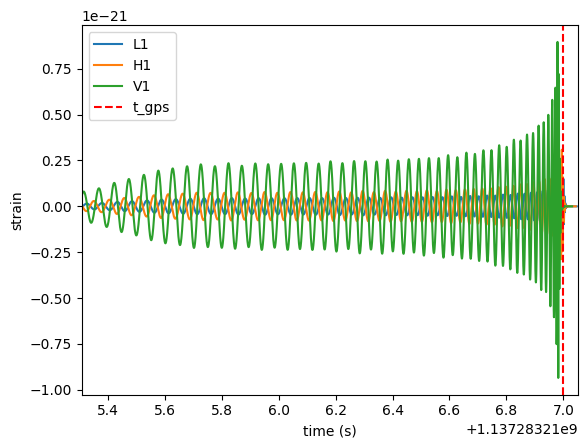

In [19]:
# Time, orientation and location of the source in the sky

ht_sim_for_IFOs = []

# We can calculate the antenna pattern for detectors at
# the specific sky location
for IFO in IFOs:
    d = Detector(IFO)

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, t_gps)
    print("{}: fp={}, fc={}".format(IFO, fp, fc))


    hp_sim = TimeSeries(hp_arr, delta_t = 1.0/srate, epoch = t_shifted[0])
    hc_sim = TimeSeries(hc_arr, delta_t = 1.0/srate, epoch = t_shifted[0])

    hp_sim.prepend_zeros(len(hp_arr)//5)
    hc_sim.prepend_zeros(len(hc_arr)//5)
    
    hp_non0_idx = np.nonzero(hp_sim)[0][0]
    hp_sim_tapered = td_taper(hp_sim, hp_sim.sample_times[0], 
                              hp_sim.sample_times[hp_non0_idx+len(hp)//10], beta=10)
    hc_sim_tapered = td_taper(hc_sim, hc_sim.sample_times[0], 
                              hc_sim.sample_times[hp_non0_idx+len(hc)//10], beta=10)
    
    ht_sim_tapered = fp*hp_sim_tapered + fc*hc_sim_tapered
    
    plt.figure(1)
    plt.plot(ht_sim_tapered.sample_times, ht_sim_tapered, label=IFO)
    plt.xlim(-t_start_to_peak*1.1,0.1)
    plt.axvline(0, c='r', ls='--')
    plt.legend()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    plt.savefig(os.path.join(out_dir, 'inj%s'%inj_num, 'waveform.png'), dpi=200)
    plt.savefig(os.path.join(plot_dir, 'inj%s'%inj_num, 'waveform.png'), dpi=200)

    # The projection process can also take into account the rotation of the
    # earth using the project wave function.
    
    hp_sim_tapered.start_time = hc_sim_tapered.start_time = ht_sim_tapered.start_time + t_gps
    ht_sim_tapered = d.project_wave(hp_sim_tapered, hc_sim_tapered, ra, dec, pol)
    
    plt.figure(2)
    plt.plot(ht_sim_tapered.sample_times, ht_sim_tapered, label=IFO)
    plt.xlim(t_gps-t_start_to_peak, t_gps+0.05)
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    plt.legend()
    plt.savefig(os.path.join(out_dir, 'inj%s'%inj_num, 'waveform_time_shifted.png'), dpi=200)
    plt.savefig(os.path.join(plot_dir, 'inj%s'%inj_num, 'waveform_time_shifted.png'), dpi=200)

    fig3 = plt.figure(3)
    plt.plot(ht_sim_tapered.sample_times, ht_sim_tapered, label=IFO)
    plt.xlim(t_gps-rough_dur, t_gps+0.05)
    plt.xlabel('time (s)')
    plt.ylabel('strain')

    ht_sim_for_IFOs.append(ht_sim_tapered)

plt.axvline(t_gps, c='r', ls='--', label='t_gps')
plt.legend()
fig3.savefig(os.path.join(out_dir, 'inj%s'%inj_num, 'waveform_time_shifted_zoomed.png'), dpi=200)
fig3.savefig(os.path.join(plot_dir, 'inj%s'%inj_num, 'waveform_time_shifted_zoomed.png'), dpi=200)
print('\n')

## Generate Zeroes

In [20]:
flow = f_low

noise_in_IFOs = []
snrs_in_IFOs = []
seed_dict = {}

for (IFO, signal_in_IFO) in zip(IFOs, ht_sim_for_IFOs):
    
    delta_f = 1/1024
    flen = int(2048 / delta_f) + 1
    
    if IFO=='L1' or IFO=='H1':
        psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
    elif IFO=='V1':
        psd = pycbc.psd.AdvVirgo(flen, delta_f, flow)
    
    signal_freq_domain = signal_in_IFO.to_frequencyseries(delta_f=delta_f)
    snr = sigma(signal_freq_domain, psd = psd, low_frequency_cutoff=flow)
    snrs_in_IFOs.append(snr)
    
    print('Optimal SNR in %s ='%IFO, snr)
    
    seed_dict[IFO] = np.random.randint(100000)

    # Generate 1024 seconds of noise at srate
    noise_len = 1024
    delta_t = 1.0/srate
    noise_tsamples = int(noise_len / delta_t)
    #noise_data = pycbc.noise.noise_from_psd(noise_tsamples, delta_t, psd, seed=seed_dict[IFO])
    noise_data = np.zeros((noise_tsamples,))
    noise_shifted = TimeSeries(noise_data, delta_t = 1.0/srate, epoch = t_gps-noise_len/2)
    noise_in_IFOs.append(noise_shifted)
    
    print(noise_len, "seconds of zeroes generated for", IFO, '\n')

Optimal SNR in L1 = 9.942911215073021
1024 seconds of zeroes generated for L1 

Optimal SNR in H1 = 16.960307446490884
1024 seconds of zeroes generated for H1 

Optimal SNR in V1 = 40.26530329842474
1024 seconds of zeroes generated for V1 



## Generate data and frame files

In [21]:
print('Generating frame files...')
for (IFO, noise_IFO, signal) in zip(IFOs, noise_in_IFOs, ht_sim_for_IFOs):
    noise_tgps_idx = np.where(noise_IFO.sample_times.data == t_gps)[0]
    signal_tgps_idx = np.where(signal.sample_times.data == t_gps)[0]
    embed_start_idx = (noise_tgps_idx - signal_tgps_idx)[0]

    gw_data = noise_IFO.data
    gw_data[embed_start_idx:embed_start_idx+len(signal)] = \
        noise_IFO.data[embed_start_idx:embed_start_idx+len(signal)] + signal.data
    gw_data_ts = TimeSeries(gw_data, delta_t = 1.0/srate, epoch = noise_IFO.start_time)
    
    frame.write_frame("%s/inj%s/%s.gwf"%(out_dir, inj_num, IFO), "%s:%s"%(IFO, nr_approx), gw_data_ts)
    print('%s.gwf generated'%IFO)
print('\n')

Generating frame files...
L1.gwf generated
H1.gwf generated
V1.gwf generated




## Write metadata in txt file

In [23]:
print('Writing metadata...')
with open(out_dir+'/inj%s/metadata.txt'%inj_num, 'w+') as f:
    f.write('Injection parameters and details for inj%s\n\n'%inj_num)
    f.write('Simulation Alias: %s\n\n'%nr_approx)
    
    f.write('Simulation properties from metadata:\n')
    for key in list(table_sim_metadata[nr_approx].keys()):
        f.write('\t%s = %s\n'%(key, table_sim_metadata[nr_approx][key]))
    f.write('\nt_ref (in seconds) = %s\n'%t_ref_in_sec)
    f.write('Note: t_ref is the time before which the data is not reliable. ')
    f.write('Hence, any data before t_ref has been removed. ')
    f.write('All values mentioned above are in 1 solar mass units.\n\n')
    
    f.write('Derived quantities from the values in metadata:\n')
    f.write(f'x_ref = {x_ref}\n')
    f.write(f'f_low = {f_low}\n')
    f.write('chi_eff_ref = %s\n'%chi_eff_ref)
    f.write('chi_p_ref = %s\n'%chi_p_ref)
    f.write(f'spin1_a = {spin1_a}\n')
    f.write(f'spin1_azimuthal = {spin1_azimuthal}\n')
    f.write(f'spin1_polar = {spin1_polar}\n')
    f.write(f'spin2_a = {spin2_a}\n')
    f.write(f'spin2_azimuthal = {spin2_azimuthal}\n')
    f.write(f'spin2_polar = {spin2_polar}\n')
    #f.write('e0 at %sHz (start of PE) = %s\n\n'%(f_low, e0_table[nr_approx]['e0']))
    
    f.write('\nIFOs = %s\n'%IFOs)
    f.write('Channel names in gwf files:\n')
    for IFO in IFOs:
        f.write('\t%s.gwf ===> \'%s:%s\'\n\n'%(IFO, IFO, nr_approx))
        
    f.write('\nNote: This is a zero noise injection\n\n')
    
    f.write('Waveform properties:\n')
    f.write('Note: the waveform is tapered between the window of ')
    f.write('%1.3fs to %1.3fs\n\n'%(hp_sim.sample_times[0], 
                                    hp_sim.sample_times[hp_non0_idx+len(hp)//10]))
    f.write('Modes included: %s\n'%modes)
    f.write('q = %s\nM = %s\nm1 = %s\nm2 = %s\nm_chirp = %s\neta = %s'%(q, M, m1, m2, m_chirp, eta))
    f.write('\nDL = %s\ninclination = %s\n'%(DL, iota))
    f.write('ra = %s\ndec = %s\npol = %s\n\n'%(ra, dec, pol))
    f.write('t_gps = %s\n\n'%t_gps)
    f.write('sampling rate = %s\n\n'%srate)
    f.write("Waveform ends %s seconds after peak.\n"%t_peak_to_end)
    f.write("Full simulation length = %s seconds\n\n"%ht_sim_tapered.duration)
    #f.write("Rough signal duration, after %s Hz = %1.3f seconds.\n"%(f_low, rough_dur))
    
    f.write('Preliminary SNR calculation of optimal SNR:\n')
    for (IFO, snr) in zip(IFOs, snrs_in_IFOs):
        f.write('\tSNR_%s = %s\n'%(IFO, snr))
    f.close()
print('Process complete.')

Writing metadata...
Process complete.
